# Projet AARN : Classification des emails en SPAM et HAM

#### Etudiantes : <br>
- Manel OUCHAR 191931047502 <br>
- Hadjer BENALI <br>
- Serine ISSAAD <br>
- Lyna TATA 191931069491 <br>

### __Etape 0: Importation des librairies et des outils nécessaires au travail__

- __NLTK (Natural Language Toolkit)__ : est une bibliothèque de traitement de langage naturel qui offre une gamme de méthodes et d'outils pour le prétraitement et l'analyse de texte. Pour notre classifier SPAM/HAM, nous utilisons NLTK pour effectuer des tâches telles que le stemming (réduction des mots à leur radical). Cela nous permet de normaliser les mots dans les emails, en regroupant différentes formes d'un même mot sous une forme commune, ce qui facilite l'analyse et la comparaison des termes. De plus, nous utilisons également les stopwords de NLTK, qui sont des mots courants et non informatifs tels que "et", "mais", "de", etc..., et nous les retirons des emails pour améliorer la pertinence des termes restants.

- __Scikit-learn__ : est une bibliothèque d'apprentissage automatique qui propose une implémentation de divers algorithmes d'apprentissage automatique. Nous utilisons Scikit-learn pour entraîner des modèles tels que SVM, Bayes naïfs... Ces modèles sont utilisés pour classifier les emails en SPAM ou HAM. Scikit-learn nous fournit également des métriques telles que l'exactitude, la précision et le rappel, ce qui nous permet de comparer les performances de différents modèles et d'évaluer l'efficacité de notre classifier.

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import email
import string
import torch
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import os
import warnings
from collections import Counter
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [60]:
nltk.download("stopwords") # Télécharge les ensembles de mots vides (stop words) de NLTK
#Ce sont des mots très courants et généralement peu informatifs tels que "le", "et", "mais", etc, 
#Nous allons les exclure de l'analyse du texte car elles ne contribuent pas significativement à la signification du texte.

nltk.download('wordnet')  # Télécharge le WordNet de NLTK
#C'est une base de données lexicale qui est souvent utilisé pour des tâches.
#Dans notre cas, le WordNet va nous servir lors de la lemmatisation: la réduction des mots à leur forme de base

[nltk_data] Downloading package stopwords to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
for filename in os.listdir(os.path.abspath("spam")):
    try:
        with open(os.path.join("spam", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("spam", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("spam", filename), "w", encoding="utf-8") as file:
            file.write(content)
for filename in os.listdir(os.path.abspath("ham")):
    try:
        with open(os.path.join("ham", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("ham", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("ham", filename), "w", encoding="utf-8") as file:
            file.write(content)

In [62]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class clean_dataset(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""

            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)
            else:
                body = b.get_payload(decode=True)  # récupérer le corp de l'email
            soup = BeautifulSoup(body, "html.parser")
            text = soup.get_text().lower()
             # dollars
            text = text.replace('$', " dollar ")
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE)  # remove links
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE)  # remove email addresses
            text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
            text = re.sub(r'\d+', 'nombre', text, flags=re.MULTILINE)
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words]  # remove stop words
            words_list = [lemmatizer.lemmatize(w) for w in words_list]
            text_list.append(' '.join(words_list))
        return np.array(text_list)

In [63]:
spam = []
ham = []

#creation of the spam list
for filename in os.listdir(os.path.abspath("spam")):
    with open(os.path.join("spam", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        spam.append(mail)

#creation of the ham list
for filename in os.listdir(os.path.abspath("ham")):
    with open(os.path.join("ham", filename), "r", encoding="utf-8") as file_content:
        mail = file_content.read()
        ham.append(mail)

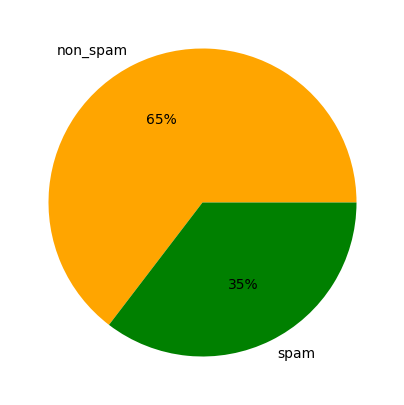

In [64]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['non_spam', 'spam']
colors = ['orange', 'green']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

In [65]:
email_to_text = clean_dataset()
text_ham = email_to_text.transform(ham)
text_spam = email_to_text.transform(spam)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [66]:
text_ham = text_ham.tolist()
text_spam = text_spam.tolist()

In [67]:
print(text_ham[0])

date wed nombre aug nombre nombre nombre chris garrigues messageid emailaddr cant reproduce error repeatable like every time without fail debug log pick happening nombre pickit exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombre sequence mercury nombre exec pick inbox list lbrace lbrace subject ftp rbrace rbrace nombre sequence mercury nombre ftocpickmsgs nombre hit nombre marking nombre hit nombre tkerror syntax error expression int note run pick command hand delta dollar pick inbox list lbrace lbrace subject ftp rbrace rbrace nombre sequence mercury nombre hit thats nombre hit come obviously version nmh im using delta dollar pick version pick nmhnombre compiled fuchsiacsmuozau sun mar nombre nombre ict nombre relevant part mhprofile delta dollar mhparam pick seq sel list since pick command work sequence actually one thats explicit command line search popup one come mhprofile get created kre p still using version code form day ago havent able reach cv repository today 

In [68]:
text_ham_words = []
for email in text_ham:
    words = email.split()
    text_ham_words.extend(words)

text_spam_words = []
for email in text_spam:
    words = email.split()
    text_spam_words.extend(words)

all_text = text_ham_words+text_spam_words

print(len(all_text))

# Filter the vocabulary to keep only words that appear at least K times in the concatenated list of strings
K = 10

word_counts = Counter(all_text)  # Count occurrences of each word
unique_words = set(all_text)  # Remove duplicate words

print(len(unique_words))

filtered_vocab = [word for word in unique_words if word_counts[word] >= K]
print(len(filtered_vocab))



559582
37021
6057


#### __2.2. Extraction de caractéristiques :__
Nous avons choisis de représenter les caractéristiques par comptage, c'est pourquoi nous utilisons la classe "CountVectorizer" de Scikit-learn qui convertie le vocabulaire filtré en une représentation vectorielle, où chaque mot du vocabulaire correspond à une dimension du vecteur. Ainsi, chaque email sera représenté par un vecteur qui indique la présence ou l'absence des termes du vocabulaire dans cet email.

In [69]:
vectorizer = CountVectorizer() # Compte le nombre d'occurences de chaque mot
vectorizer.fit(filtered_vocab)
# Sauvegarder le vocabulaire dans un fichier JSON
with open("vocabulaire.json", "w") as outfile:
    json.dump(filtered_vocab, outfile)

In [70]:
X = text_ham+text_spam # Liste contenant l'ensemble des emails
y = len(text_ham)*[0] + len(text_spam)*[1] # Liste contenant les étiquettes pour chaque email 0 pour ham et 1 pour spam

### __Etape 2: Classification__

In [71]:
# Diviser le dataset en un ensemble d'entainemet et un ensemble de test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Transformation de comptage des caractéristiques aux ensembles d'entrainement et de test à l'aide de vectorizer
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [72]:
print("Nombre d'emails d'entrainement : ", len(X_train))
print("Nombre d'emails de test : ", len(X_test))

Nombre d'emails d'entrainement :  2763
Nombre d'emails de test :  1185


In [99]:
import time

accuracies = []
Time = []

- #### __SVM__: 
Nous utilisons un SVM avec un noyau simple linéaire.

In [122]:
from sklearn import svm

start_time = time.time()

model = svm.SVC(kernel='linear',C=0.1)
model.fit(X_train,y_train)
predictions = model.predict(X_test) # Entrainement

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, predictions)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle SVM = ", accuracy*100)
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle SVM =  98.05907172995781
Temps =  8.975573301315308 secondes


Text(0.5, 0, 'False positive rate')

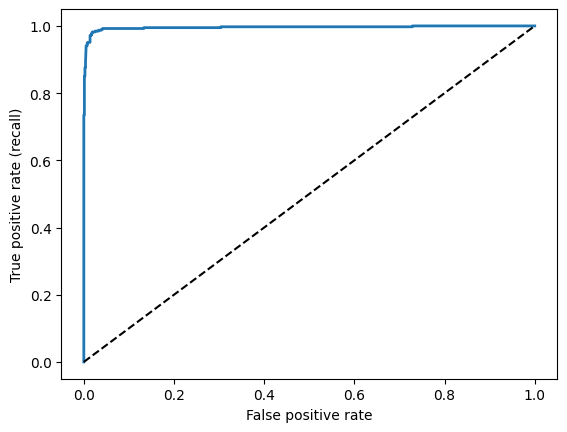

In [123]:
train_prediction_scores = model.decision_function(X_train)
test_prediction_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, test_prediction_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

__Analyse__ :
Le modèle SVM a atteint une excellente précision de 97.89% dans la classification des emails en spam et ham, ce qui indique une capacité élevée à distinguer les deux classes.

- #### __KNN__: 

In [124]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

# creer un classifieur KNN k=5
knn = KNeighborsClassifier(n_neighbors=5)
# Fit  avec training data x-train et y-train
knn.fit(X_train, y_train)
# faire la prediction sur test data
y_pred = knn.predict(X_test)

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, y_pred)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle KNN =  {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle KNN =  81.7721518987%
Temps =  3.055790662765503 secondes


Text(0.5, 0, 'False positive rate')

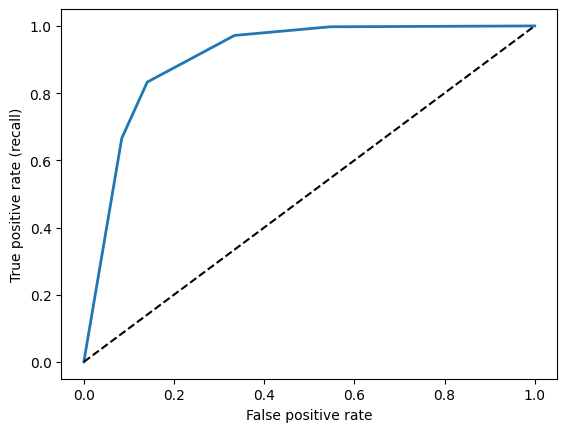

In [125]:
# Calculate the probabilities for each class
y_scores = knn.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __Régression Logistique__: 


In [129]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()

# creer l'objet de logistic regression 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Predire les labels
y_pred = logreg.predict(X_test)

# Evaluer la performance du model
accuracy = logreg.score(X_test, y_test)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle de régression logistique = {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle de régression logistique = 98.6497890295%
Temps =  2.9945926666259766 secondes


Text(0.5, 0, 'False positive rate')

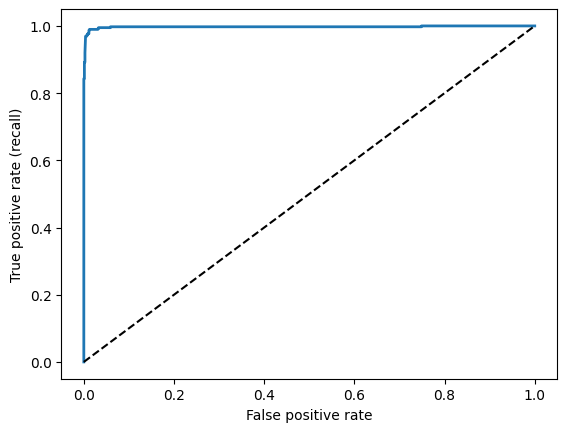

In [130]:
# Calculate the predicted probabilities for the positive class (spam)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __Réseau de neurones__: 

In [131]:
from keras.layers import Dense
from keras.models import Sequential

start_time = time.time()

model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
        optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0,
        validation_data=(X_test, y_test))


loss, accuracy = model.evaluate(X_test, y_test)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du réseau de neurones = {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")


38/38 [==============================] - 0s 5ms/step - loss: 0.0554 - accuracy: 0.9840
Exactitude du réseau de neurones = 98.3966231346%
Temps =  34.984925270080566 secondes


38/38 [==============================] - 0s 2ms/step


Text(0.5, 0, 'False positive rate')

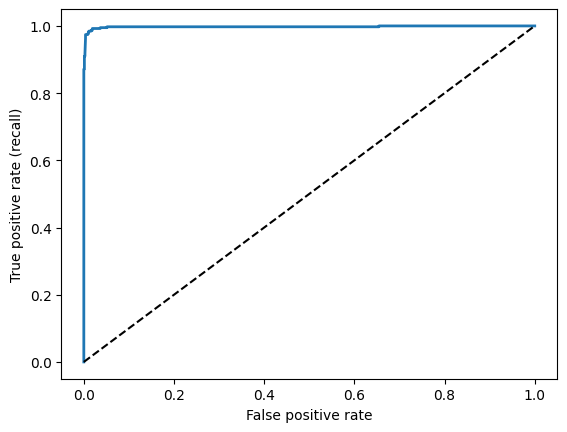

In [132]:
y_pred_prob = model.predict(X_test)
y_pred_prob = y_pred_prob.flatten()  # Flatten the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __Naive Bayes__ :

In [134]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

# Créer une instance du modèle Naive Bayes
model = MultinomialNB()
# Entraîner le modèle
model.fit(X_train, y_train)
# Effectuer des prédictions sur les données de test
predictions = model.predict(X_test)

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, predictions)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle Naive Bayes =  {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")


Exactitude du modèle Naive Bayes =  97.2151898734%
Temps =  0.371232271194458 secondes


Text(0.5, 0, 'False positive rate')

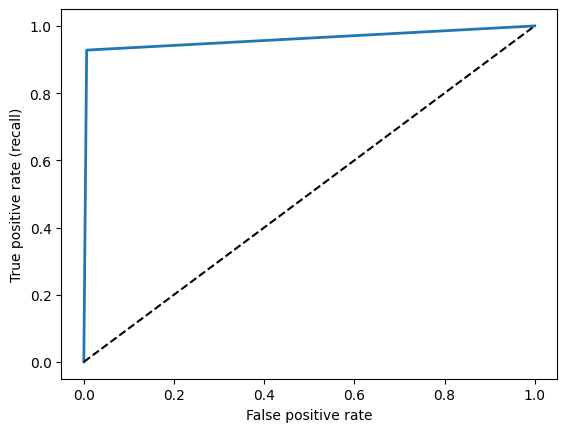

In [135]:
y_pred_prob = model.predict(X_test)
y_pred_prob = y_pred_prob.flatten()  # Flatten the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

- #### __LinearSVC__ : 

In [139]:
from sklearn.svm import LinearSVC

start_time = time.time()

# Créer une instance du modèle LinearSVC
model = LinearSVC()
# Entraîner le modèle
model.fit(X_train, y_train)
# Effectuer des prédictions sur les données de test
predictions = model.predict(X_test)

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, predictions)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Exactitude du modèle Linear SVC =  {0:.10f}%".format(accuracy*100))
print("Temps = ", end_time - start_time, "secondes")

Exactitude du modèle Linear SVC =  97.2151898734%
Temps =  0.6934294700622559 secondes


Text(0.5, 0, 'False positive rate')

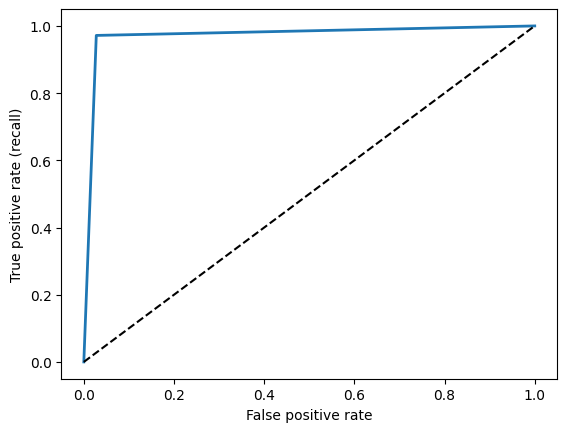

In [140]:
y_pred_prob = model.predict(X_test)
y_pred_prob = y_pred_prob.flatten()  # Flatten the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

In [141]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense# Create the LSTM model

model = Sequential()
model.add(LSTM(units=64))
model.add(Dense(units=1, activation='sigmoid'))

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\Asus Zenbook Flip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Asus Zenbook Flip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Asus Zenbook Flip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Asus Zenbook Flip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Asus Zenbook Flip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Asus Zenbook Flip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_6' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 6010)
    
    Call arguments received by layer 'sequential_6' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 6010), dtype=int64)
      • training=True
      • mask=None
